# Energy Prediction

In [57]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from keras.preprocessing.sequence import TimeseriesGenerator
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.metrics import mean_absolute_percentage_error, mean_absolute_error, mean_squared_error, r2_score
import seaborn as sns
import warnings
import time
warnings.filterwarnings('ignore')

## Read Data and Correct errors

In [58]:
df = pd.read_csv("../datsets/dataset1/archive/HomeC.csv", delimiter = ',')
 

#Dropped last line (null)
df = df.iloc[:-1] #drop last row


#Time is wrong, data was recorded minutely
time_index = pd.date_range('2016-01-01 05:00', periods=len(df),  freq='min')  
time_index = pd.DatetimeIndex(time_index)
df = df.set_index(time_index)
df = df.drop(['time'], axis=1)

#Retirar [kW]
df.columns = [col.replace(' [kW]', '') for col in df.columns]


#Somar colunas 
df['Furnace'] = df[['Furnace 1','Furnace 2']].sum(axis=1)
df['Kitchen'] = df[['Kitchen 12','Kitchen 14','Kitchen 38']].sum(axis=1)
df = df.drop(['Kitchen 12','Kitchen 14','Kitchen 38'], axis=1)
df = df.drop(['Furnace 1','Furnace 2'], axis=1)

#this column is the same as use
df = df.drop(columns=['House overall'])

#useless
df = df.drop(columns=['summary'])
df = df.drop(columns=['icon'])

#SAVE
#df.to_csv('../datsets/dataset1/archive/HomeC.csv', index=False)


df



use       gen  Dishwasher  Home office    Fridge  \
2016-01-01 05:00:00  0.932833  0.003483    0.000033     0.442633  0.124150   
2016-01-01 05:01:00  0.934333  0.003467    0.000000     0.444067  0.124000   
2016-01-01 05:02:00  0.931817  0.003467    0.000017     0.446067  0.123533   
2016-01-01 05:03:00  1.022050  0.003483    0.000017     0.446583  0.123133   
2016-01-01 05:04:00  1.139400  0.003467    0.000133     0.446533  0.122850   
...                       ...       ...         ...          ...       ...   
2016-12-16 03:25:00  1.601233  0.003183    0.000050     0.041783  0.005267   
2016-12-16 03:26:00  1.599333  0.003233    0.000050     0.041750  0.005233   
2016-12-16 03:27:00  1.924267  0.003217    0.000033     0.042033  0.004983   
2016-12-16 03:28:00  1.978200  0.003217    0.000050     0.042100  0.005333   
2016-12-16 03:29:00  1.990950  0.003233    0.000050     0.042100  0.004917   

                     Wine cellar  Garage door      Barn      Well  Microwave  \
2016-01-01 05:00:00     0.006983     0.013083  0.031350  0.001017   0.004067   
2016-01-01 05:01:00     0.006983     0.013117  0.031500  0.001017   0.004067   
2016-01-01 05:02:00     0.006983     0.013083  0.031517  0.001000   0.004067   
2016-01-01 05:03:00     0.006983     0.013000  0.031500  0.001017   0.004067   
2016-01-01 05:04:00     0.006850     0.012783  0.031500  0.001017   0.004067   
...                          ...          ...       ...       ...        ...   
2016-12-16 03:25:00     0.008667     0.013483  0.032283  0.000983   0.003800   
2016-12-16 03:26:00     0.008433     0.013433  0.032200  0.000950   0.003800   
2016-12-16 03:27:00     0.008467     0.012933  0.032283  0.001000   0.003750   
2016-12-16 03:28:00     0.008233     0.012817  0.032183  0.000950   0.003767   
2016-12-16 03:29:00     0.008133     0.012833  0.032167  0.000950   0.003767   

                     ...  apparentTemperature  pressure  windSpeed  \
2016-01-01 05:00:00  ...                29.26   1016.91       9.18   
2016-01-01 05:01:00  ...                29.26   1016.91       9.18   
2016-01-01 05:02:00  ...                29.26   1016.91       9.18   
2016-01-01 05:03:00  ...                29.26   1016.91       9.18   
2016-01-01 05:04:00  ...                29.26   1016.91       9.18   
...                  ...                  ...       ...        ...   
2016-12-16 03:25:00  ...                29.45   1011.49       6.72   
2016-12-16 03:26:00  ...                29.45   1011.49       6.72   
2016-12-16 03:27:00  ...                29.45   1011.49       6.72   
2016-12-16 03:28:00  ...                29.45   1011.49       6.72   
2016-12-16 03:29:00  ...                29.45   1011.49       6.72   

                     cloudCover  windBearing  precipIntensity  dewPoint  \
2016-01-01 05:00:00  cloudCover        282.0           0.0000     24.40   
2016-01-01 05:01:00  cloudCover        282.0           0.0000     24.40   
2016-01-01 05:02:00  cloudCover        282.0           0.0000     24.40   
2016-01-01 05:03:00  cloudCover        282.0           0.0000     24.40   
2016-01-01 05:04:00  cloudCover        282.0           0.0000     24.40   
...                         ...          ...              ...       ...   
2016-12-16 03:25:00        0.31        186.0           0.0101     31.27   
2016-12-16 03:26:00        0.31        186.0           0.0101     31.27   
2016-12-16 03:27:00        0.31        186.0           0.0101     31.27   
2016-12-16 03:28:00        0.31        186.0           0.0101     31.27   
2016-12-16 03:29:00        0.31        186.0           0.0101     31.27   

                     precipProbability   Furnace   Kitchen  
2016-01-01 05:00:00               0.00  0.082617  0.000567  
2016-01-01 05:01:00               0.00  0.084533  0.000567  
2016-01-01 05:02:00               0.00  0.083017  0.000617  
2016-01-01 05:03:00               0.00  0.175417  0.000650  
2016-01-01 05:04:00               0.00  0.300917  0.000783  
...                 

In [59]:
#CORRECT cloudCover COLUMN

print(df['cloudCover'].unique())

#replace missing values with the next valid observation 
df['cloudCover'].replace(['cloudCover'], method='bfill', inplace=True) 

#change to floar
df['cloudCover'] = df['cloudCover'].astype('float')

df['cloudCover'].unique()

['cloudCover' '0.75' '0' '1' '0.31' '0.44' '0.13' '0.19' '0.25' '0.16'
 '0.21' '0.15' '0.14' '0.27' '0.28' '0.17' '0.05' '0.1' '0.26' '0.29'
 '0.11' '0.09' '0.12' '0.06' '0.02' '0.08' '0.04' '0.35' '0.22' '0.23'
 '0.54' '0.39' '0.03' '0.07' '0.76' '0.62' '0.18' '0.79' '0.48' '0.24'
 '0.57' 0.24 1.0 0.31 0.28 0.15 0.41 0.1 0.12 0.08 0.09 0.19 0.04 0.05
 0.29 0.27 0.35 0.18 0.06 0.03 0.11 0.14 0.25 0.78 0.0 0.16 0.21 0.23 0.17
 0.75 0.26 0.2 0.76 0.13 0.77 0.46 0.07 0.55 0.02 0.01 0.51 0.47 0.5 0.4
 0.3 0.22 0.43 0.33 0.6 0.68 0.66 0.45 0.34 0.52 0.67 0.48 0.49 0.39 0.37
 0.62 0.36 0.79 0.61 0.38 0.42 0.53 0.63 0.44 0.54 0.32 0.56 0.58 0.72
 0.57 0.73 0.71 0.64 0.59]


array([0.75, 0.  , 1.  , 0.31, 0.44, 0.13, 0.19, 0.25, 0.16, 0.21, 0.15,
       0.14, 0.27, 0.28, 0.17, 0.05, 0.1 , 0.26, 0.29, 0.11, 0.09, 0.12,
       0.06, 0.02, 0.08, 0.04, 0.35, 0.22, 0.23, 0.54, 0.39, 0.03, 0.07,
       0.76, 0.62, 0.18, 0.79, 0.48, 0.24, 0.57, 0.41, 0.78, 0.2 , 0.77,
       0.46, 0.55, 0.01, 0.51, 0.47, 0.5 , 0.4 , 0.3 , 0.43, 0.33, 0.6 ,
       0.68, 0.66, 0.45, 0.34, 0.52, 0.67, 0.49, 0.37, 0.36, 0.61, 0.38,
       0.42, 0.53, 0.63, 0.32, 0.56, 0.58, 0.72, 0.73, 0.71, 0.64, 0.59])

In [60]:
df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 503910 entries, 2016-01-01 05:00:00 to 2016-12-16 03:29:00
Freq: T
Data columns (total 25 columns):
 #   Column               Non-Null Count   Dtype  
---  ------               --------------   -----  
 0   use                  503910 non-null  float64
 1   gen                  503910 non-null  float64
 2   Dishwasher           503910 non-null  float64
 3   Home office          503910 non-null  float64
 4   Fridge               503910 non-null  float64
 5   Wine cellar          503910 non-null  float64
 6   Garage door          503910 non-null  float64
 7   Barn                 503910 non-null  float64
 8   Well                 503910 non-null  float64
 9   Microwave            503910 non-null  float64
 10  Living room          503910 non-null  float64
 11  Solar                503910 non-null  float64
 12  temperature          503910 non-null  float64
 13  humidity             503910 non-null  float64
 14  visibility           50391

In [61]:
#GROUP DATA PER HOUR INTERVAL

#data  is in KwH, basta fazer a media
df = df.resample('H').mean()

#DROP LAST LINE (INCOMPLETE HOUR)
df.drop(df.tail(1).index,inplace=True)

#SOME FEATURES THAT MIGHT BE IMPORTANT
df['month'] = df.index.month
df['weekday'] = df.index.day
df['hour'] = df.index.hour


df

use       gen  Dishwasher  Home office    Fridge  \
2016-01-01 05:00:00  1.044130  0.003307    0.000064     0.241814  0.037861   
2016-01-01 06:00:00  0.918167  0.003422    0.000099     0.043294  0.075522   
2016-01-01 07:00:00  0.714736  0.003448    0.000043     0.043416  0.059486   
2016-01-01 08:00:00  0.960013  0.003447    0.000138     0.065014  0.060412   
2016-01-01 09:00:00  0.639836  0.003439    0.000060     0.043392  0.035106   
...                       ...       ...         ...          ...       ...   
2016-12-15 22:00:00  1.210261  0.004140    0.000071     0.041784  0.033194   
2016-12-15 23:00:00  1.096999  0.004137    0.000075     0.041853  0.044236   
2016-12-16 00:00:00  1.276585  0.004109    0.000059     0.041711  0.050492   
2016-12-16 01:00:00  1.260231  0.004141    0.000100     0.041921  0.049140   
2016-12-16 02:00:00  1.100358  0.004164    0.000085     0.041900  0.050063   

                     Wine cellar  Garage door      Barn      Well  Microwave  \
2016-01-01 05:00:00     0.063351     0.013046  0.038881  0.001042   0.021652   
2016-01-01 06:00:00     0.112942     0.012836  0.039181  0.001021   0.004216   
2016-01-01 07:00:00     0.007184     0.013299  0.034439  0.001014   0.004246   
2016-01-01 08:00:00     0.007045     0.012925  0.034195  0.001016   0.004274   
2016-01-01 09:00:00     0.007143     0.013220  0.031830  0.001014   0.004258   
...                          ...          ...       ...       ...        ...   
2016-12-15 22:00:00     0.008212     0.012851  0.031983  0.040707   0.003049   
2016-12-15 23:00:00     0.008119     0.012814  0.032249  0.000992   0.003084   
2016-12-16 00:00:00     0.105546     0.012526  0.030902  0.040522   0.003001   
2016-12-16 01:00:00     0.123134     0.012743  0.031992  0.000999   0.003104   
2016-12-16 02:00:00     0.065749     0.012957  0.031680  0.000993   0.003111   

                     ...  cloudCover  windBearing  precipIntensity   dewPoint  \
2016-01-01 05:00:00  ...    0.750000   282.100000         0.000000  24.383333   
2016-01-01 06:00:00  ...    0.750000   284.733333         0.000000  23.866000   
2016-01-01 07:00:00  ...    0.750000   279.400000         0.000000  23.469000   
2016-01-01 08:00:00  ...    0.750000   265.000000         0.000000  24.202667   
2016-01-01 09:00:00  ...    0.625000   265.500000         0.000000  24.423333   
...                  ...         ...          ...              ...        ...   
2016-12-15 22:00:00  ...    0.216667   256.716667         0.000000  20.654667   
2016-12-15 23:00:00  ...    0.816000   189.666667         0.000373  28.414667   
2016-12-16 00:00:00  ...    0.310000   197.633333         0.004313  29.379167   
2016-12-16 01:00:00  ...    0.310000   197.900000         0.010600  30.864333   
2016-12-16 02:00:00  ...    0.310000   191.833333         0.010392  31.118333   

                     precipProbability   Furnace   Kitchen  month  weekday  \
2016-01-01 05:00:00              0.000  0.393188  0.000821      1        1   
2016-01-01 06:00:00              0.000  0.456708  0.000749      1        1   
2016-01-01 07:00:00              0.000  0.372170  0.000726      1        1   
2016-01-01 08:00:00              0.000  0.616370  0.000806      1        1   
2016-01-01 09:00:00              0.000  0.343842  0.000796      1        1   
...                                ...       ...       ...    ...      ...   
2016-12-15 22:00:00              0.000  0.830258  0.000735     12       15   
2016-12-15 23:00:00              0.008  0.772467  0.000732     12       15   
2016-12-16 00:00:00              0.182  0.796006  0.000639     12       16   
2016-12-16 01:00:00              0.510  0.823418  0.000766     12       16   
2016-12-16 02:00:00              0.510  0.706701  0.000734     12       16   

                     hour  
2016-01-01 05:00:00     5  
2016-01-01 06:00:00     6  
2016-01-01 07:00:00     7  
2016-01-01 08:00:00     8  
2016-01-01 09:00:00     9  
...                   ...  
2016-12-15 22:00:00   

## Visualisations

<AxesSubplot:title={'center':'Energy use'}>

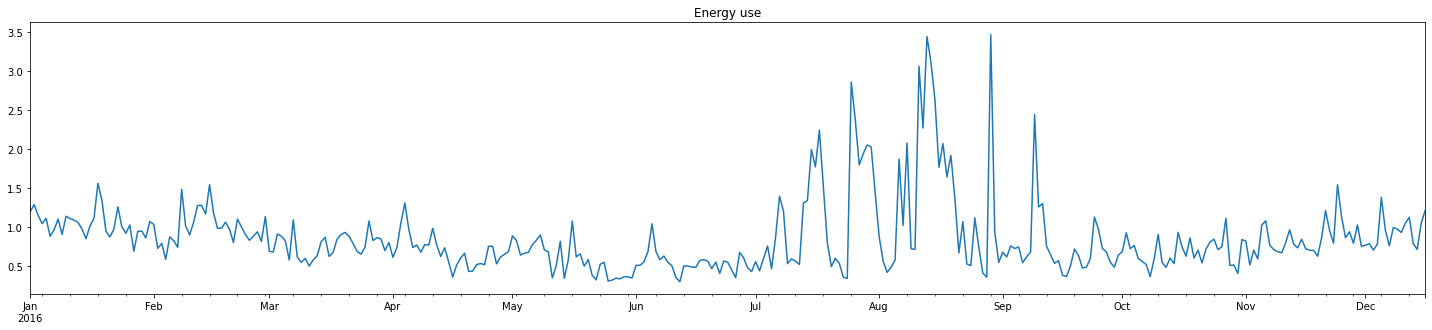

In [63]:
df['use'].resample(rule='D').mean().plot(figsize=(25,5), title="Energy use")    #group by day

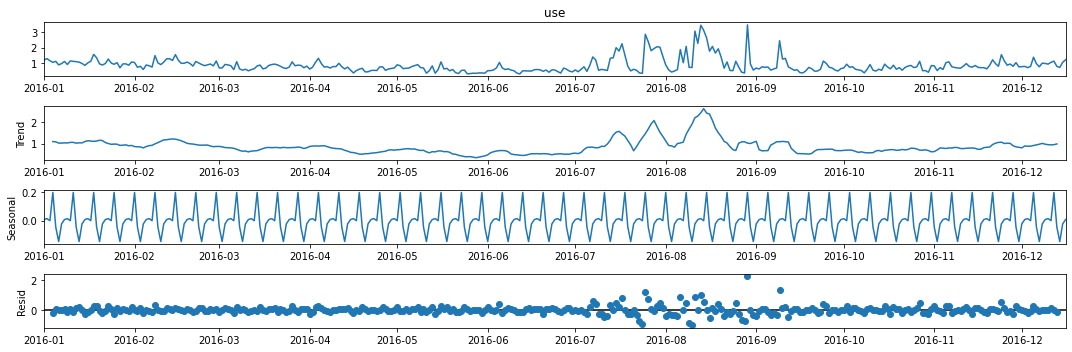

In [64]:
from statsmodels.tsa.seasonal import seasonal_decompose

plt.rc("figure", figsize=(15,5))

results = seasonal_decompose(df['use'].resample(rule='D').mean())
fig = results.plot()


# Feature Selection

[18:39:20] WARNING: ../src/learner.cc:576: 
Parameters: { "silent" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.




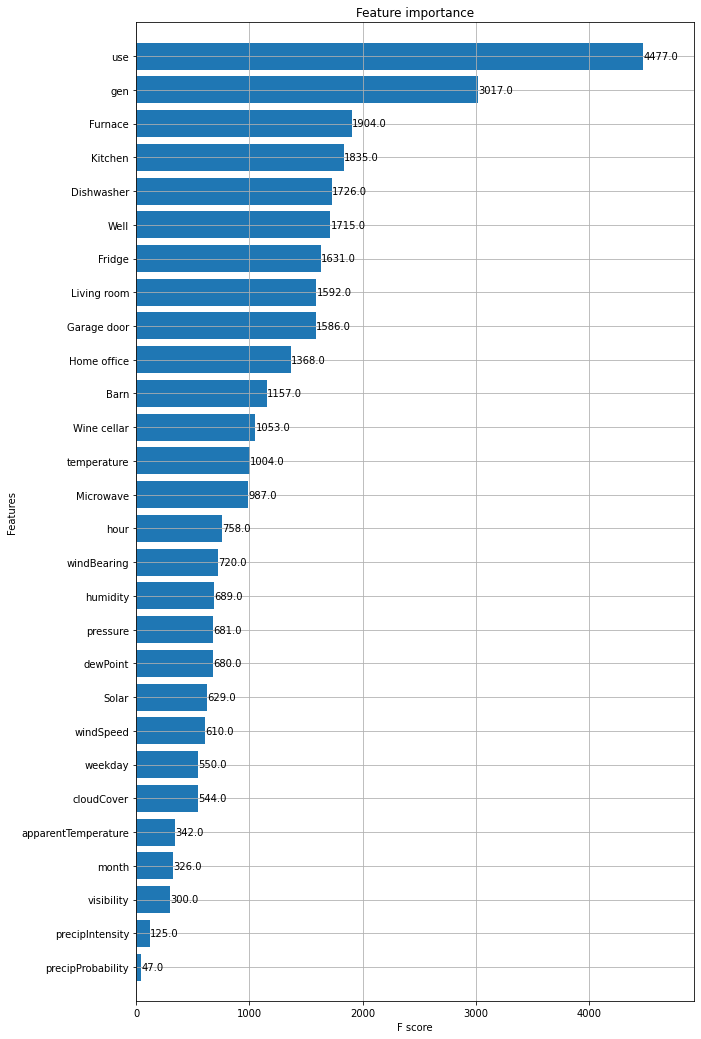

In [17]:
import xgboost as xgb

use = df["use"].values
xgb_params = {
    'eta': 0.05,
    'max_depth': 10,
    'subsample': 1.0,
    'colsample_bytree': 0.7,
    'eval_metric': 'rmse',
    'silent': 1
}
dtrain = xgb.DMatrix(df, use, feature_names=df.columns.values)
model = xgb.train(dict(xgb_params, silent=0), dtrain, num_boost_round=100)

fig, ax = plt.subplots(figsize=(10,18))
xgb.plot_importance(model, height=0.8, ax=ax)
plt.show()

importance = model.get_score(importance_type='weight')
tuples = sorted([(k, importance[k]) for k in importance], key=lambda x: x[1], reverse=True)
xgb_imp_f = [x[0] for x in tuples]

feature_selection = xgb_imp_f[:10]

# Help Functions

In [18]:
#Apply a scaler to the data

def scale(scaler, x_train, y_train, x_test, x_val=None, y_val=None):
    x_scaler = scaler()
    x_train = x_scaler.fit_transform(x_train)
    x_test = x_scaler.transform(x_test)
   
    y_scaler = scaler()
    y_train = y_scaler.fit_transform(y_train)
    
    if x_val is not None:
        x_val = x_scaler.transform(x_val)
        y_val = y_scaler.transform(y_val)
    
        return x_train, y_train, x_test, x_val, y_val,x_scaler, y_scaler

    return x_train, y_train, x_test, x_scaler, y_scaler
    


In [47]:
def predict_evaluate(model, x_test, y_scaler, y_test_UnScalled, graphName = 'Energy Usage Prediction', showplots=False):
    prediction = model.predict(x_test).reshape(-1, 1)
    prediction = y_scaler.inverse_transform(prediction)
    
    #equalTest = 7*24 - (24*30-len(prediction))
    #prediction = prediction[equalTest:]
    #y_test_UnScalled = y_test_UnScalled[equalTest:]
    

    diff = [abs(prediction[i]-y_test_UnScalled[i]) for i in range(len(prediction))]
    
    resultingPlot = plt.figure(figsize=(25,10))
    plt.plot(y_test_UnScalled, color='red', label='Original Usage')
    plt.plot(prediction, color='blue', label='Predicted Usage')
    plt.plot(diff, color='green', label='Error')
    plt.title(graphName)
    plt.ylabel('kW')
    plt.legend()
    
    mape = mean_absolute_percentage_error(y_test_UnScalled, prediction)
    mae = mean_absolute_error(y_test_UnScalled, prediction)
    maxae = max(diff)[0]
    mse = mean_squared_error(y_test_UnScalled, prediction)
    
    if showplots:
        plt.show()
        print("Mean Absolute Percentage Error: ", mape)
        print("Mean Absolute Error: ", mae)
        print("Max Absolute Error: ", maxae)
        print("Mean Squared Error: ", mse)
    
    return {"name":graphName, "resultingPlot": resultingPlot, "mape":mape, "mae":mae, "maxae":maxae, "mse":mse}

# LSTM

In [48]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout, MaxPooling2D, Conv2D, TimeDistributed, Flatten
from keras.callbacks import EarlyStopping

def define_model(past_window, num_features):
    
    #OPTIMIZAVEL
    model = Sequential()
    model.add(LSTM(units=128, return_sequences=True,input_shape=(past_window, num_features)))
    model.add(LSTM(units=64))
    model.add(Dense(units = 1))
    model.compile(optimizer = 'adam', loss = 'mean_squared_error', metrics = 'mean_absolute_error')
    #model.summary()
    
    return model

def train(model, train_generator, val_generator, showplot=False):
    early_stopping = EarlyStopping(monitor="val_loss", 
                                   patience=5, 
                                   mode="min")
    
    history = model.fit(train_generator, 
                                  epochs=32,
                                  validation_data=val_generator, 
                                  shuffle = False, 
                                  callbacks=[early_stopping],
                                  verbose=0
                                   )
    
    loss_per_epoch = history.history['loss']
    
    if showplot:
        plt.plot(range(len(loss_per_epoch)), loss_per_epoch)


def make_lstm(df, featuresNames, targetName, past_window, name='Energy Usage Prediction', showplots=False):
    num_features = len(featuresNames)
    
    features = df[featuresNames]
    target = df[targetName]
    
    #DIVIDIR EM TREINO/TESTE
    x_train, x_test, y_train, y_test = train_test_split(features.values,target.values.reshape(-1, 1), test_size=24*30, shuffle=False)
    x_train, x_val, y_train, y_val = train_test_split(x_train, y_train, test_size=0.05, shuffle=False)
   
    y_test_UnScalled = y_test[past_window:] #GUARDAR PARA COMPARAR RESULTADOS

    #SCALE
    x_train, y_train, x_test, x_val, y_val, x_scaler, y_scaler = scale(MinMaxScaler, x_train, y_train, x_test, x_val, y_val)
    
    
    batch_size=64
    train_generator = TimeseriesGenerator(x_train, y_train, length=past_window, batch_size=batch_size)
    val_generator = TimeseriesGenerator(x_val, y_val, length=past_window, batch_size=batch_size)
    test_generator = TimeseriesGenerator(x_test, y_test, length=past_window, batch_size=batch_size)

    model = define_model(past_window, num_features)
    train(model, train_generator, val_generator)

    return predict_evaluate(model, test_generator, y_scaler, y_test_UnScalled, graphName=name, showplots=showplots)


## Evaluate a bunch of LSTMs

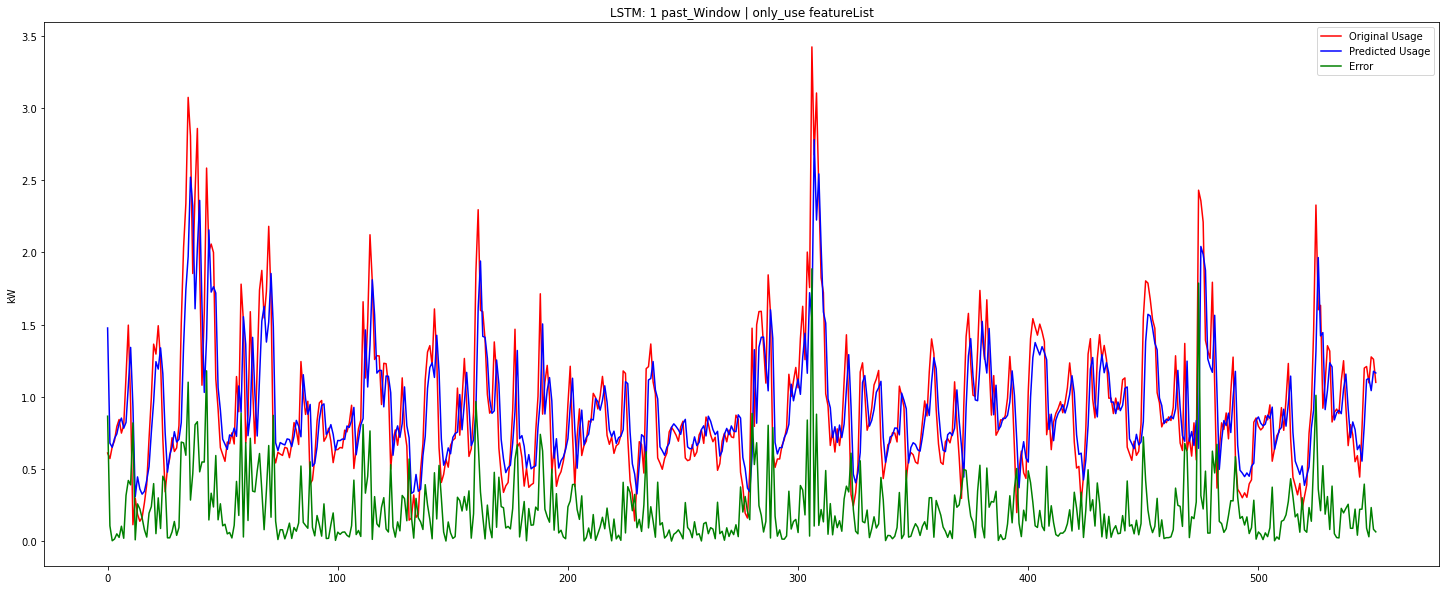

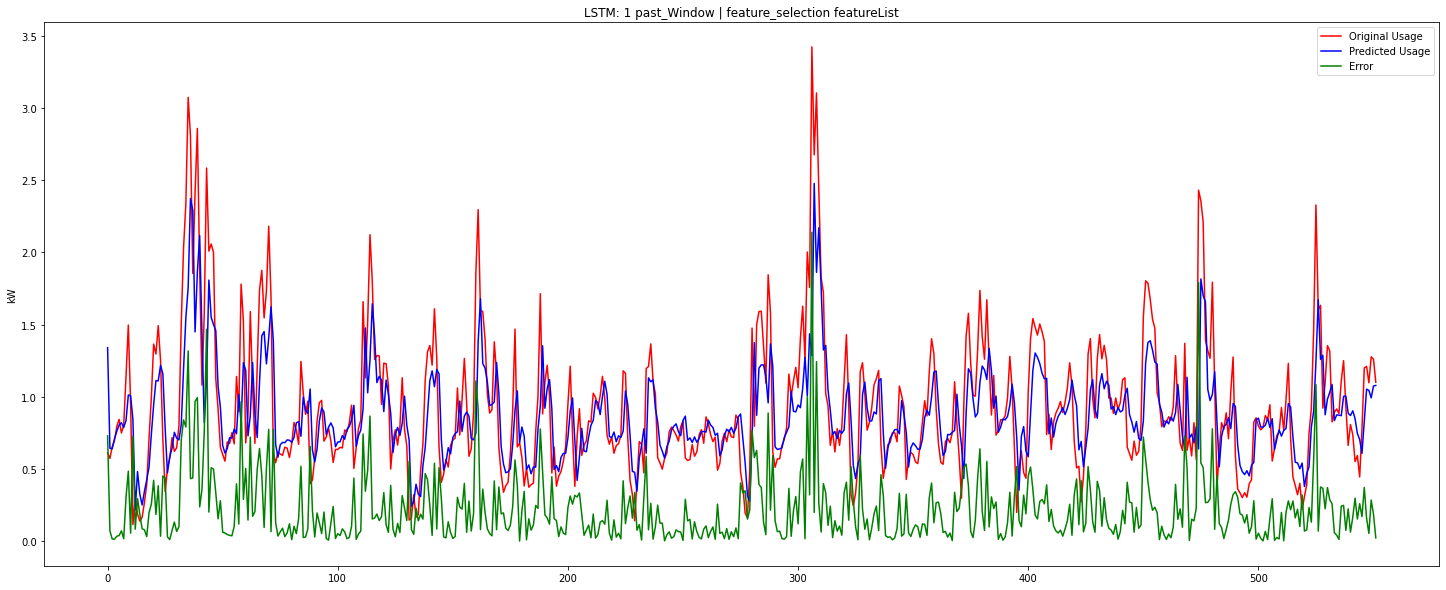

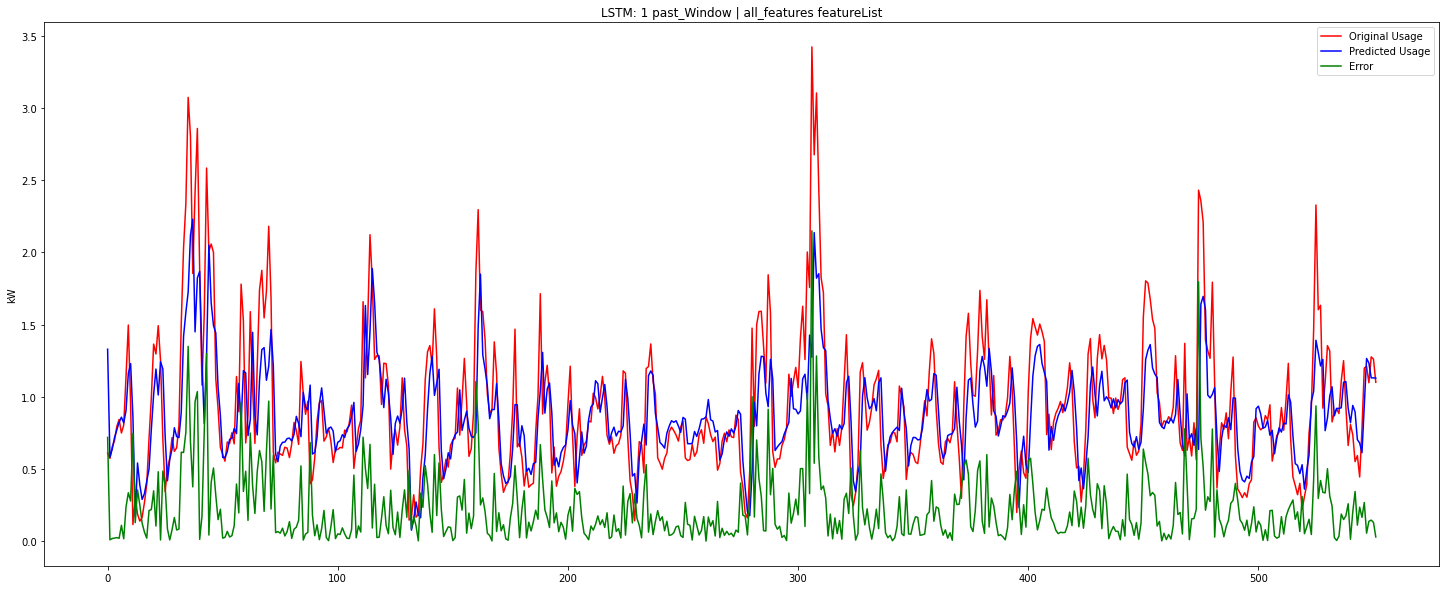

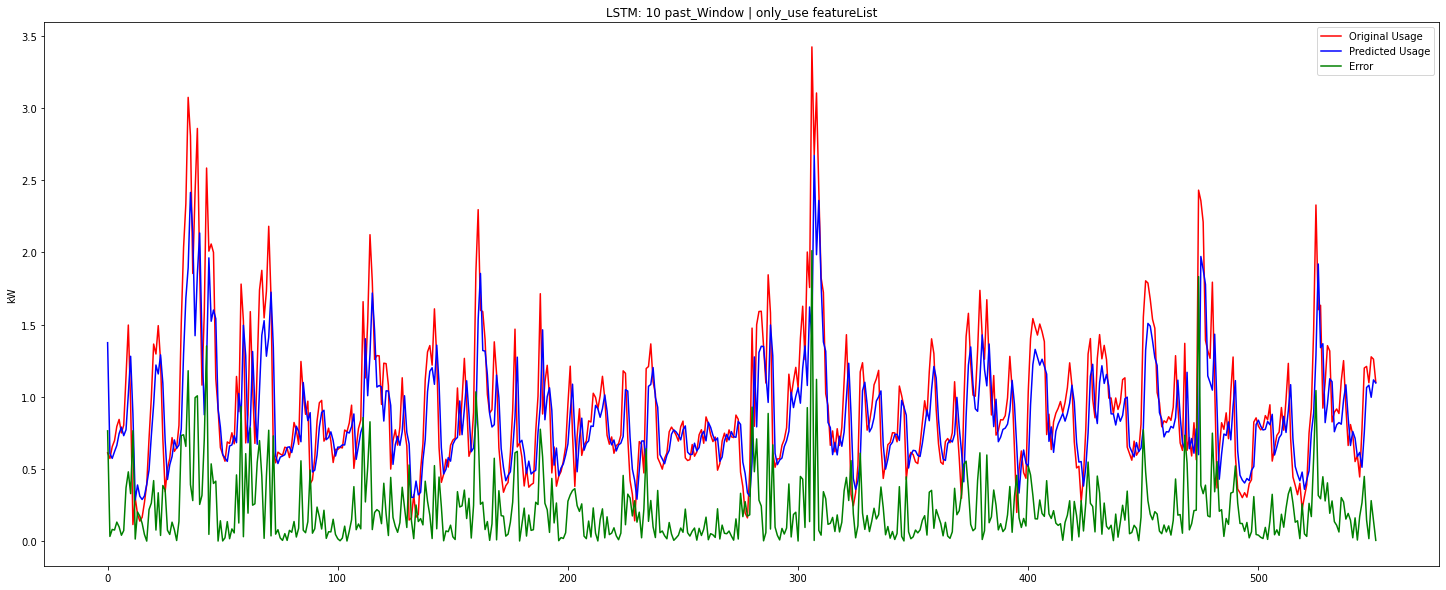

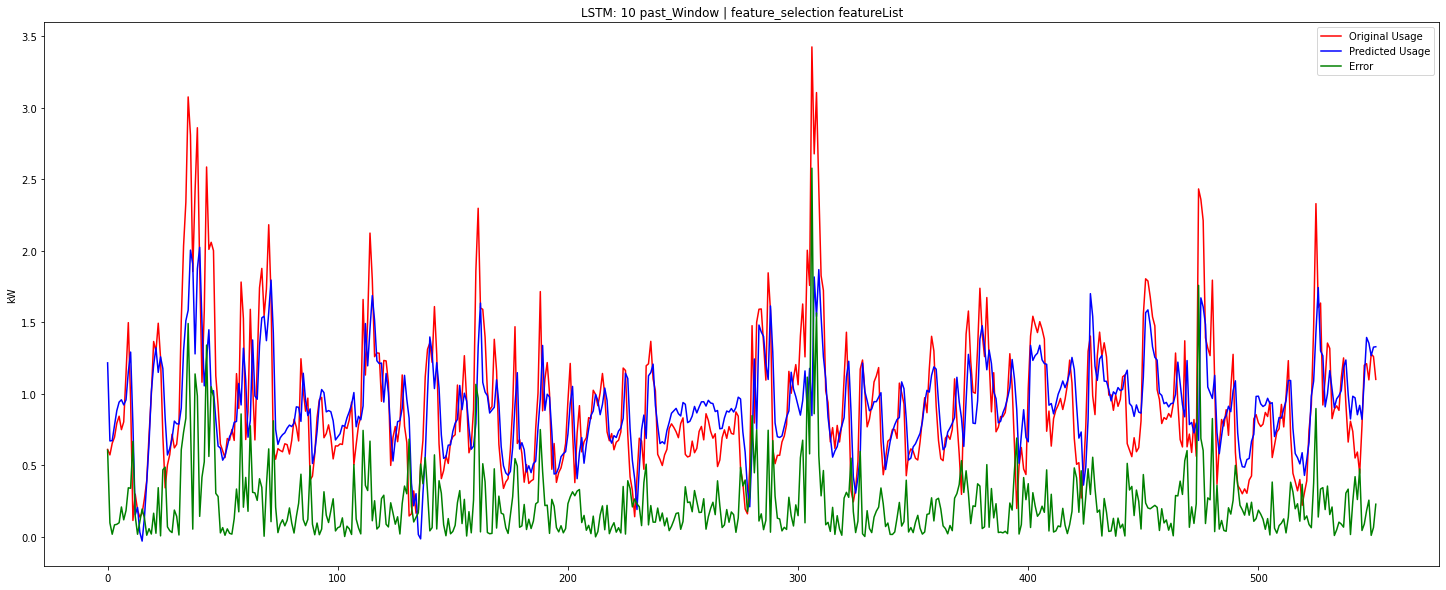

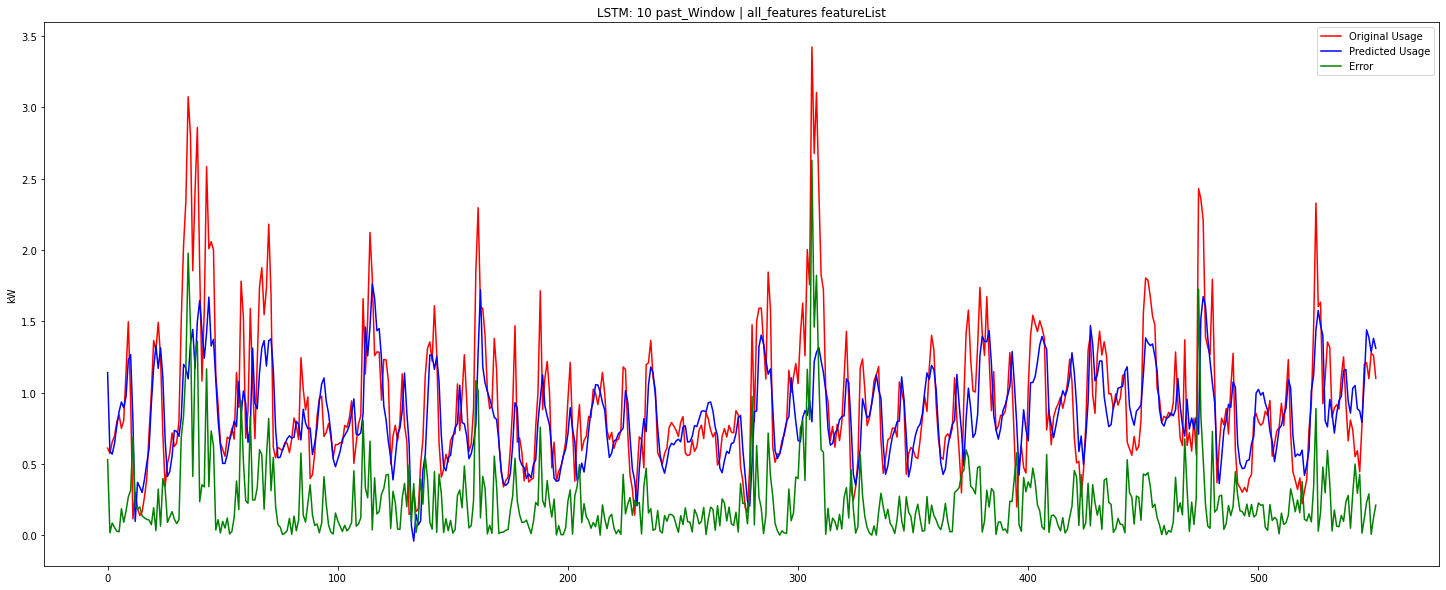

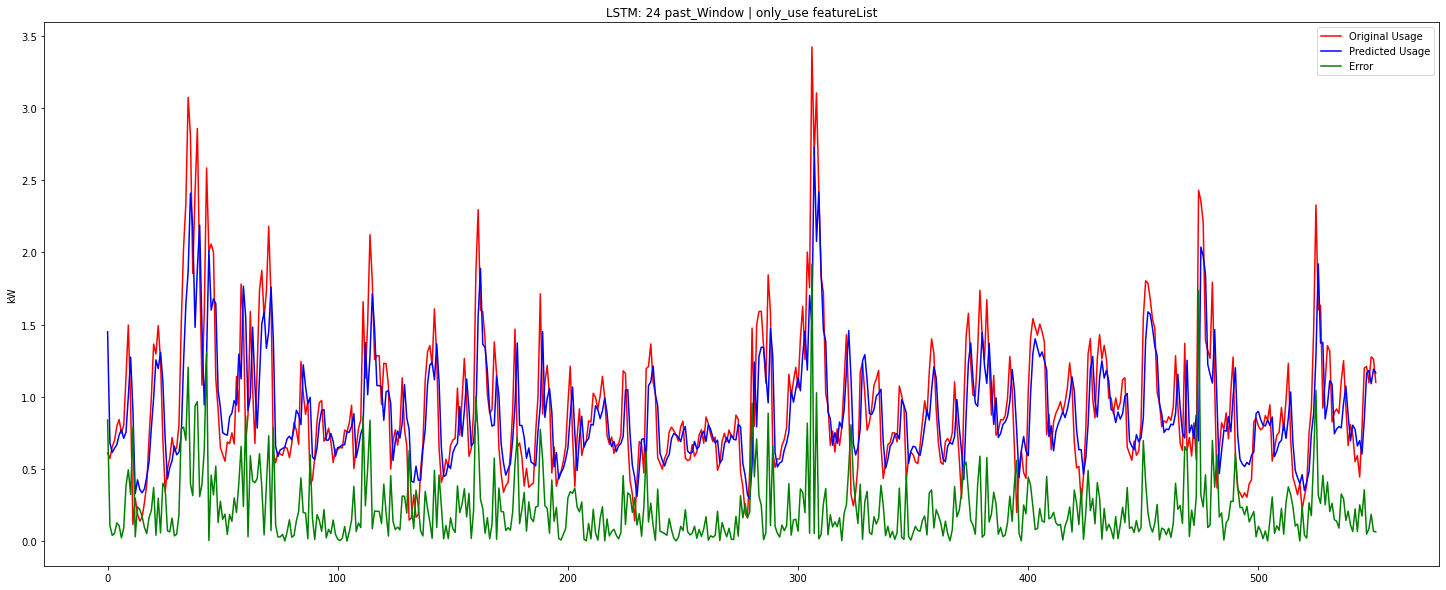

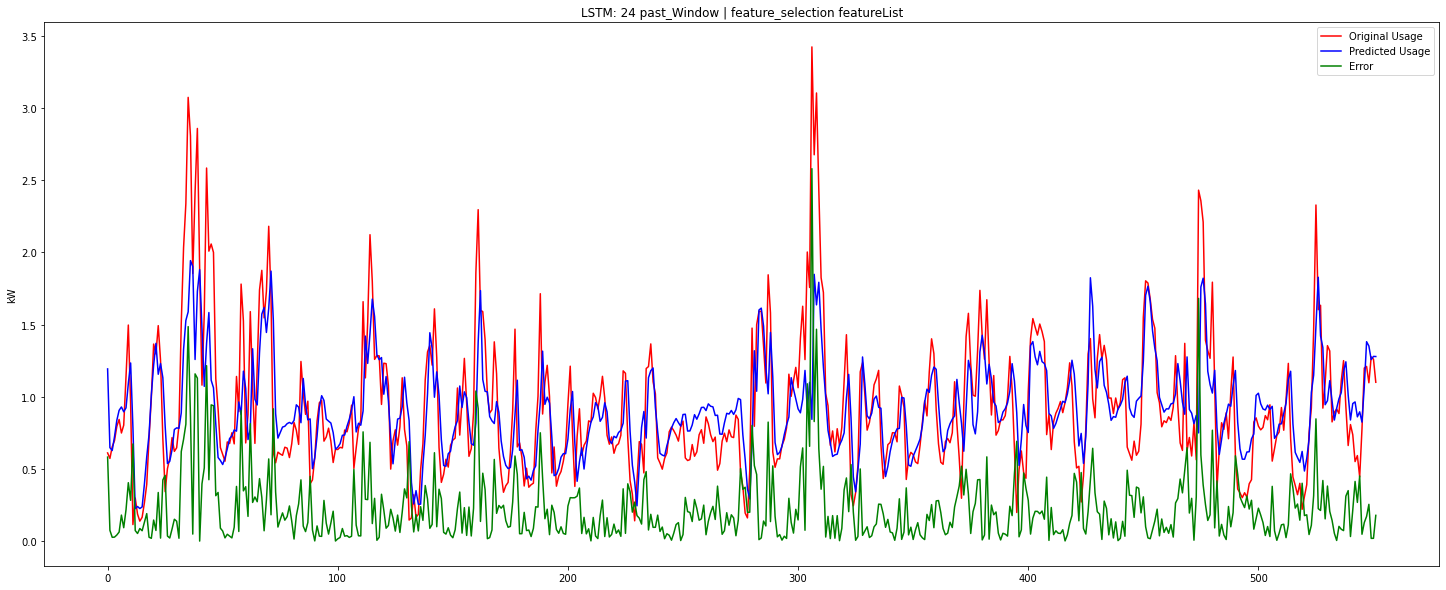

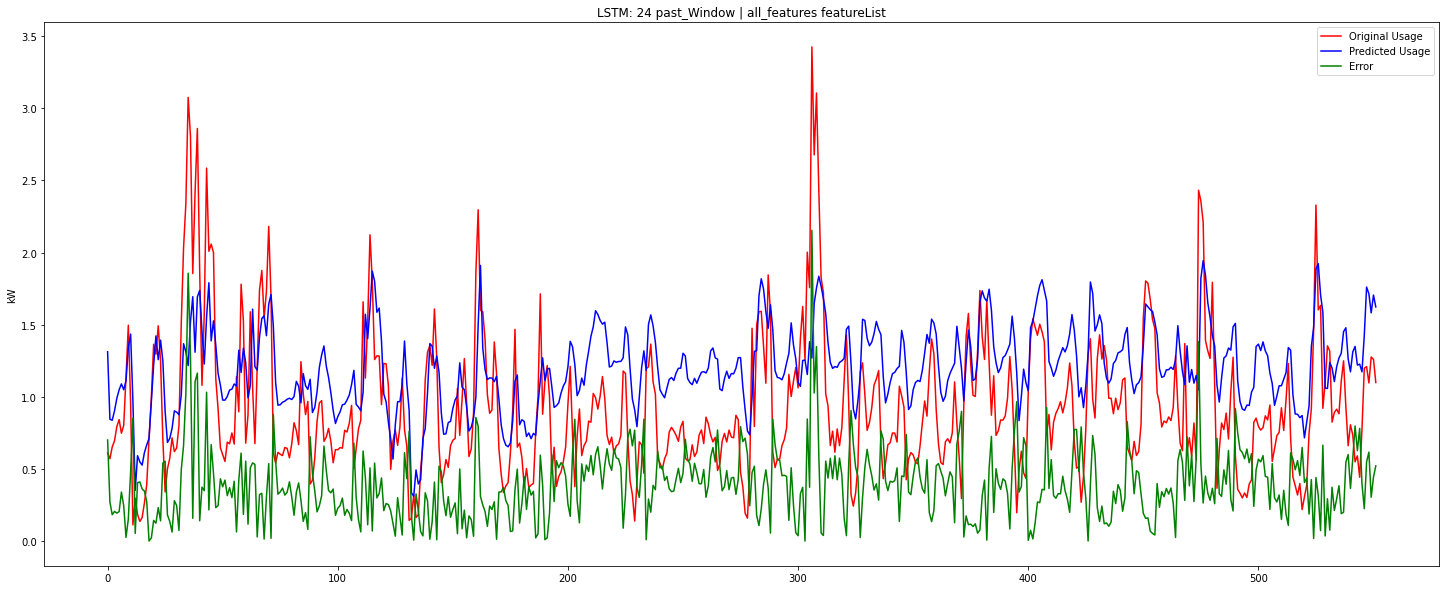

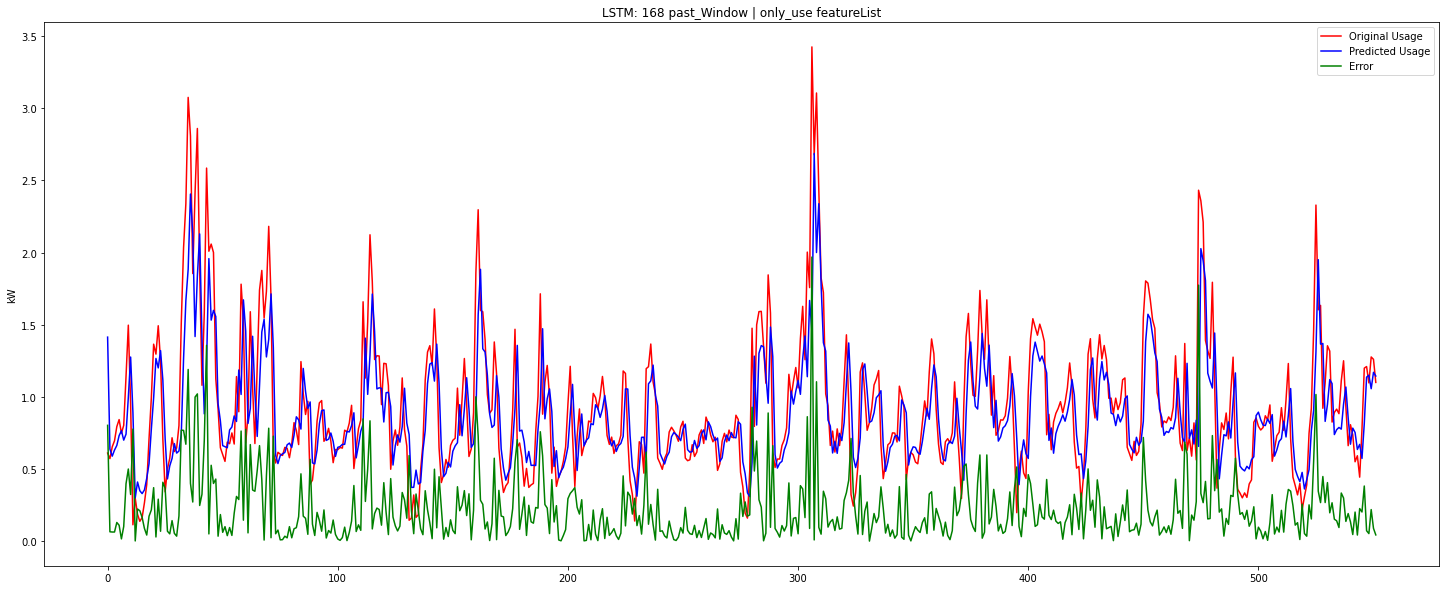

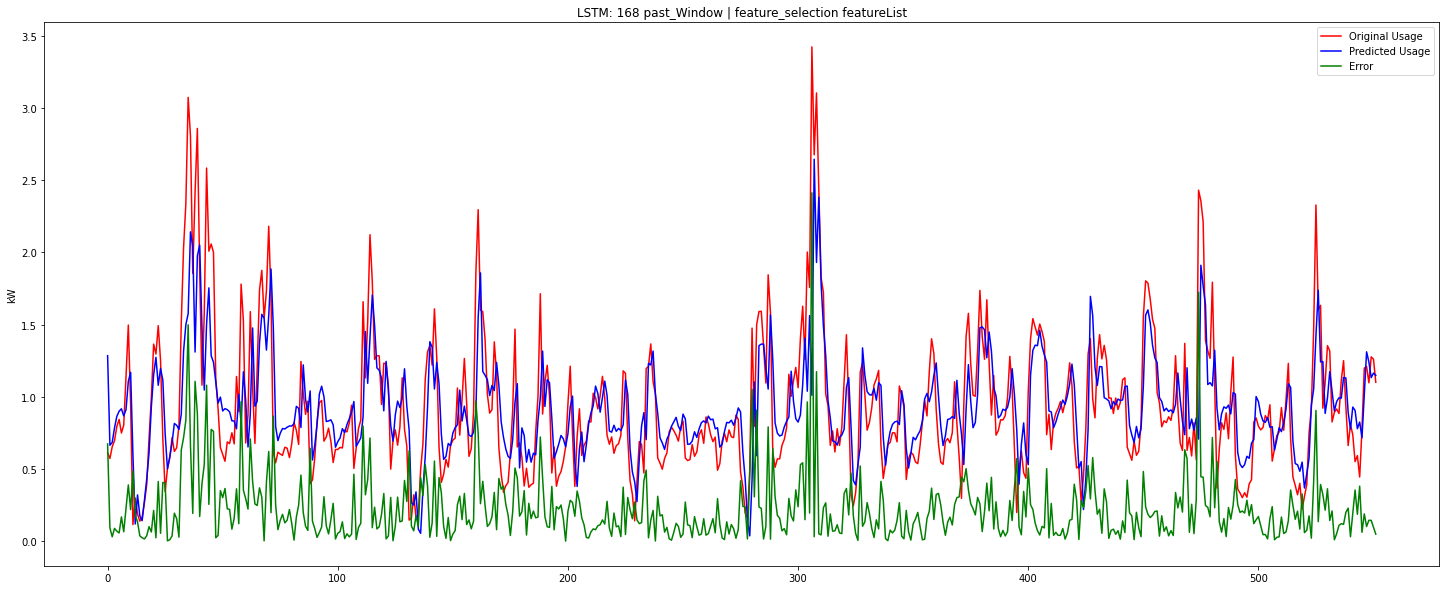

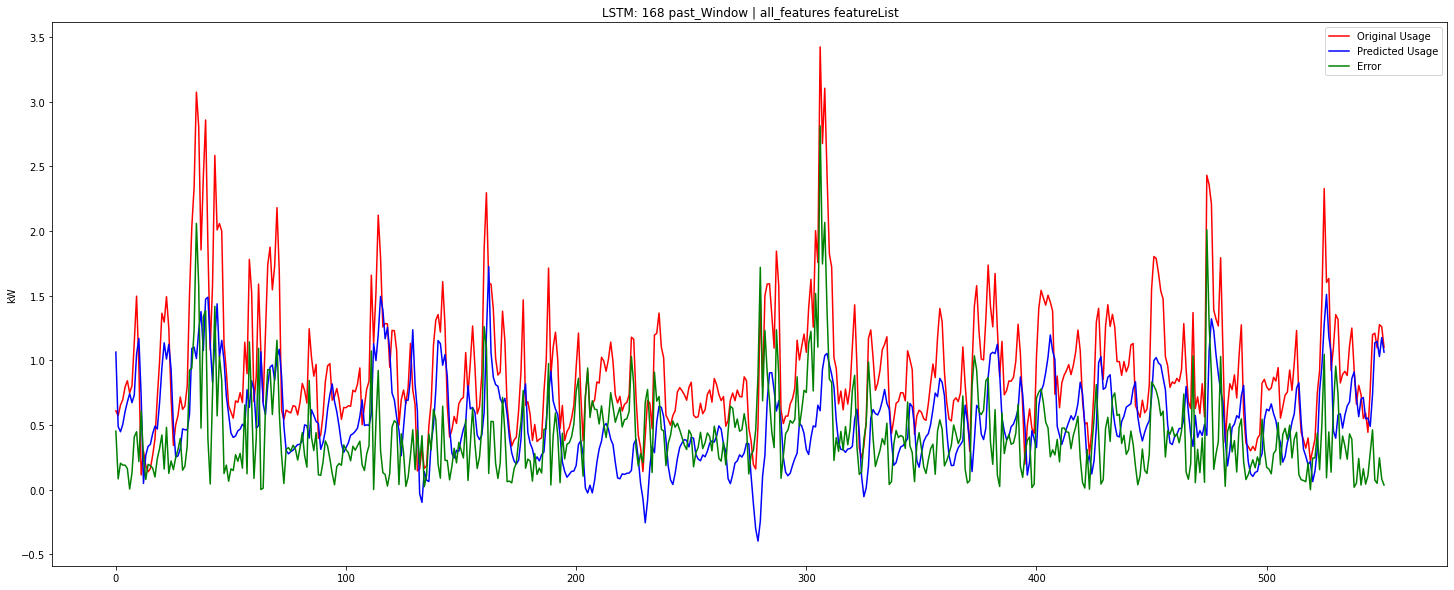

In [49]:
TARGET_NAME = "use"
PAST_WINDOWS = [1, 10, 24, 24*7]
FEATURE_NAMES = {"only_use": ["use"],
                 "feature_selection":feature_selection,
                 "all_features":list(df.columns)}

results = []

for past_window in PAST_WINDOWS:
    for featuresName, featurelist in FEATURE_NAMES.items():
        
        name = "LSTM: " + str(past_window) + " past_Window | " + featuresName + " featureList"
        result = make_lstm(df, featurelist, TARGET_NAME, past_window, name)     
        
        results.append(result)

In [50]:
from prettytable import PrettyTable

results.sort(key=lambda x: x['mape'])
t = PrettyTable(['Name', 'mape', 'mae', 'maxae', 'mse'])

for r in results:
    t.add_row([r['name'], round(r['mape'], 3), round(r['mae'], 3), round(r['maxae'], 3), round(r['mse'], 3)])

print(t)


+-------------------------------------------------------+-------+-------+-------+-------+
|                          Name                         |  mape |  mae  | maxae |  mse  |
+-------------------------------------------------------+-------+-------+-------+-------+
|      LSTM: 10 past_Window | only_use featureList      | 0.269 | 0.219 | 2.012 | 0.104 |
|     LSTM: 1 past_Window | all_features featureList    | 0.271 | 0.222 |  2.15 | 0.108 |
|    LSTM: 10 past_Window | all_features featureList    |  0.28 | 0.236 | 2.629 | 0.132 |
|  LSTM: 1 past_Window | feature_selection featureList  | 0.281 | 0.224 | 2.139 | 0.109 |
|      LSTM: 168 past_Window | only_use featureList     | 0.285 | 0.221 | 1.969 | 0.103 |
|       LSTM: 1 past_Window | only_use featureList      | 0.286 | 0.215 | 1.886 | 0.098 |
| LSTM: 168 past_Window | feature_selection featureList | 0.288 | 0.223 | 2.413 | 0.104 |
|      LSTM: 24 past_Window | only_use featureList      | 0.295 | 0.222 | 1.919 | 0.103 |
|  LSTM: 2

Melhor lstm usa janela temporal de 10 e apenas o consumo energetico  
Provavelmente é possivel optimizar a arquitectura da rede

# SVR

In [51]:
from sklearn.svm import SVR

def make_svr(df, featuresNames, targetName, past_window, svr_kernel, checkParams=False,name='Energy Usage Prediction', showplots=False):
    num_features = len(featuresNames)
    
    #SEPARATE INTO TRAIN / TEST
    features = df[featuresNames]
    target = df[targetName]
    x_train, x_test, y_train, y_test = train_test_split(features.values,target.values.reshape(-1, 1), test_size=24*30, shuffle=False)
    y_test_UnScalled = y_test[past_window:]
    
    #SCALE
    x_train, y_train, x_test, x_scaler, y_scaler = scale(StandardScaler, x_train, y_train, x_test)
    
    #TIME SERIES FORMAT
    batch_size=1
    train_generator = TimeseriesGenerator(x_train, y_train, length=past_window, batch_size=batch_size)
    test_generator = TimeseriesGenerator(x_test, y_test, length=past_window, batch_size=batch_size)
    svr_x_Train = [arr[0].flatten() for arr in train_generator]
    svr_y_Train = [arr[1].flatten() for arr in train_generator]
    svr_x_Test = [arr[0].flatten() for arr in test_generator]
    
    #TRAIN
    regressor = SVR(kernel = svr_kernel)  
    if checkParams:
        params = {"C":[0.1, 1, 10], "gamma": [0.1, 0.01, 0.001]}
        regressor = GridSearchCV(regressor, params)
        regressor.fit(svr_x_Train, svr_y_Train)
        print(regressor.best_params_)
    else:
        regressor.fit(svr_x_Train, svr_y_Train)
    
    #PREDICT
    return predict_evaluate(regressor, svr_x_Test, y_scaler, y_test_UnScalled, graphName=name, showplots=showplots)
    

## Evaluate a bunch of SVRs

a
a
a
a
a
a
a
a
a
a


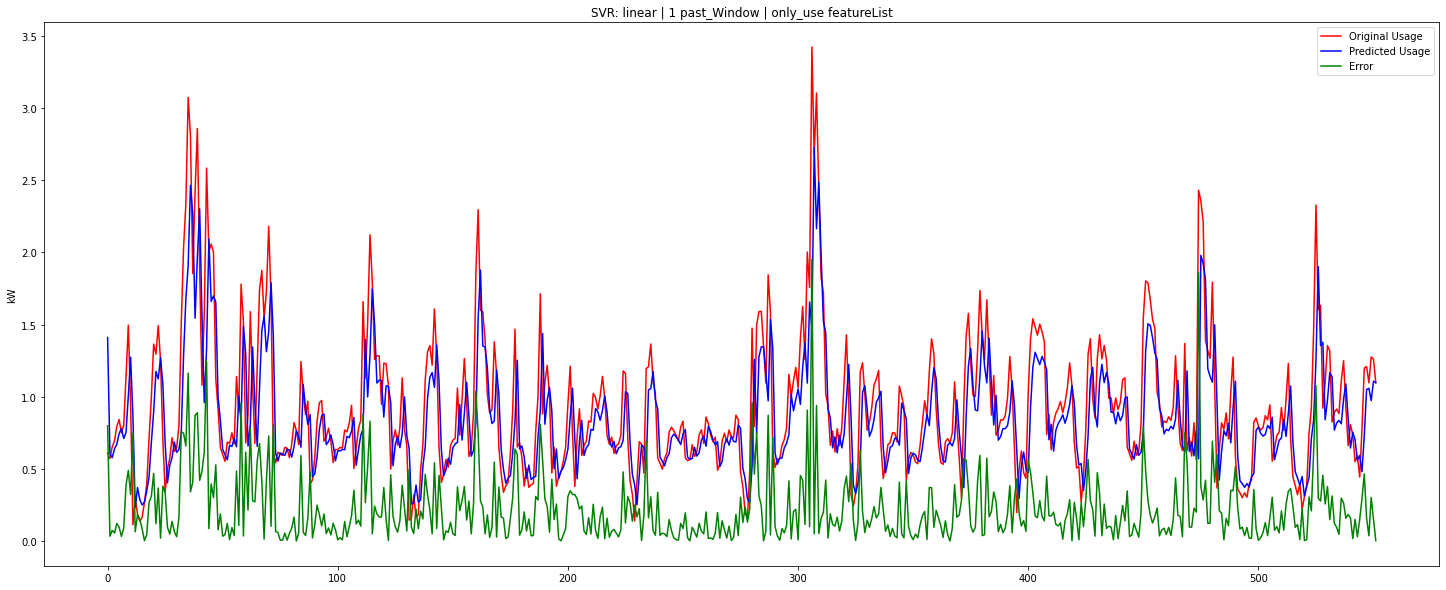

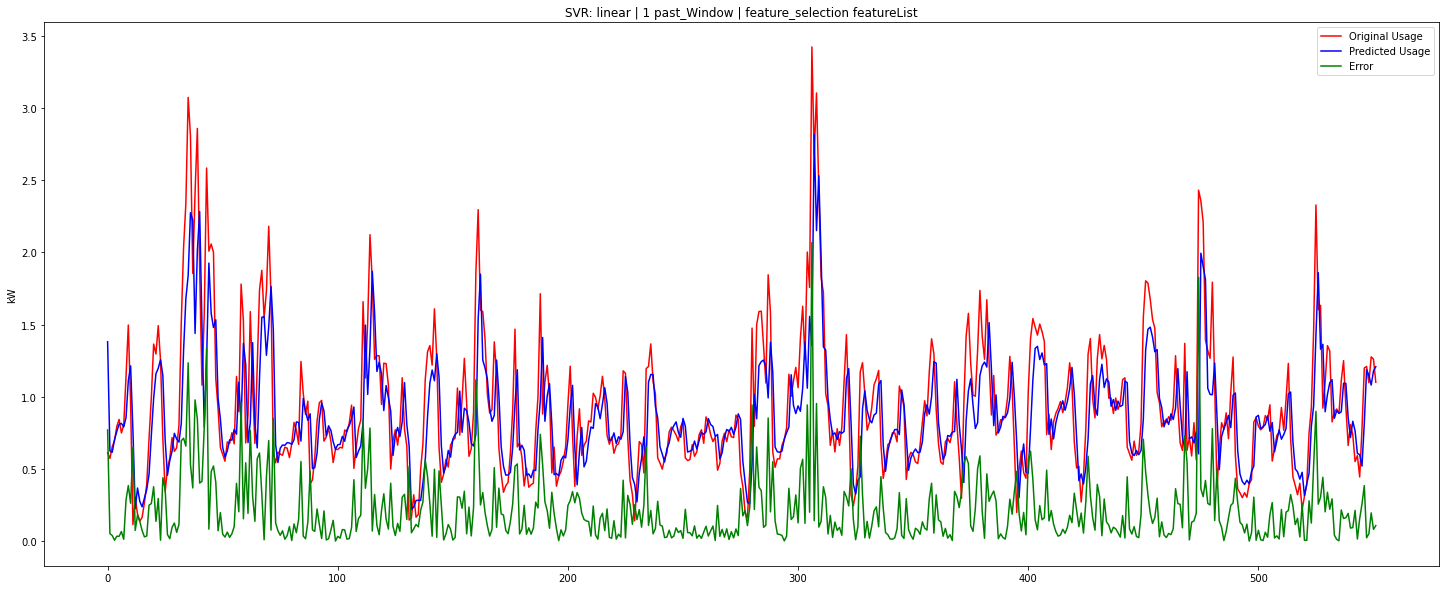

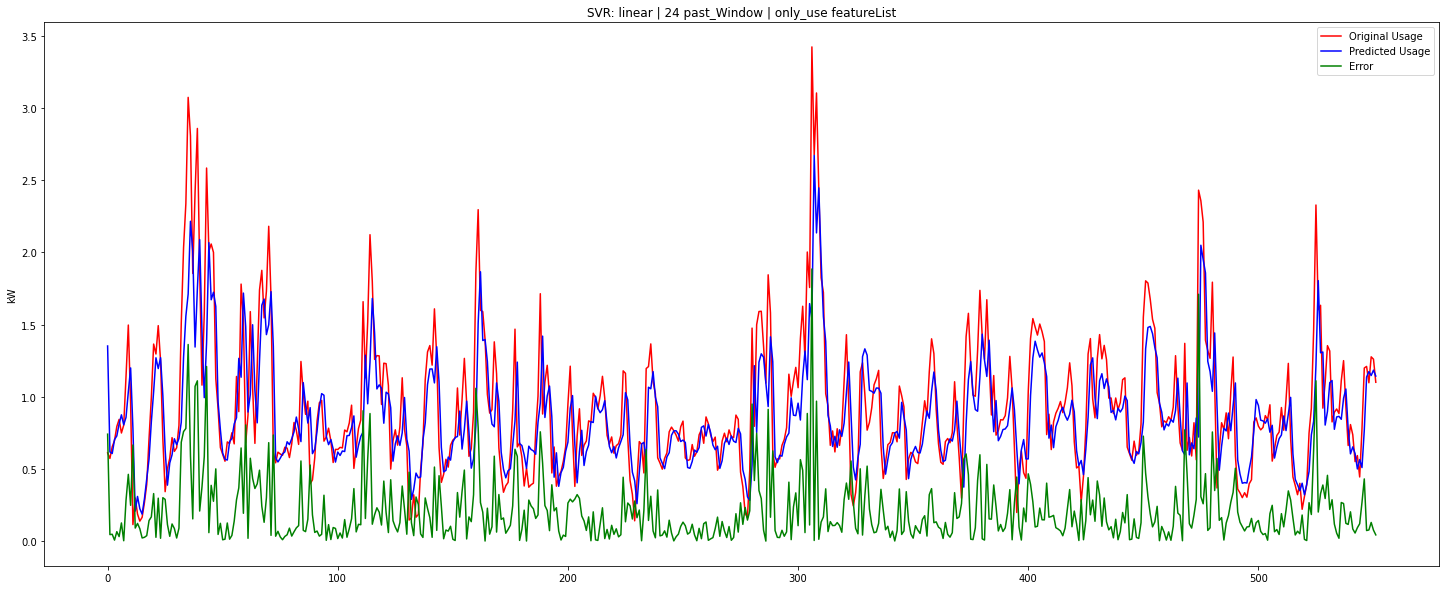

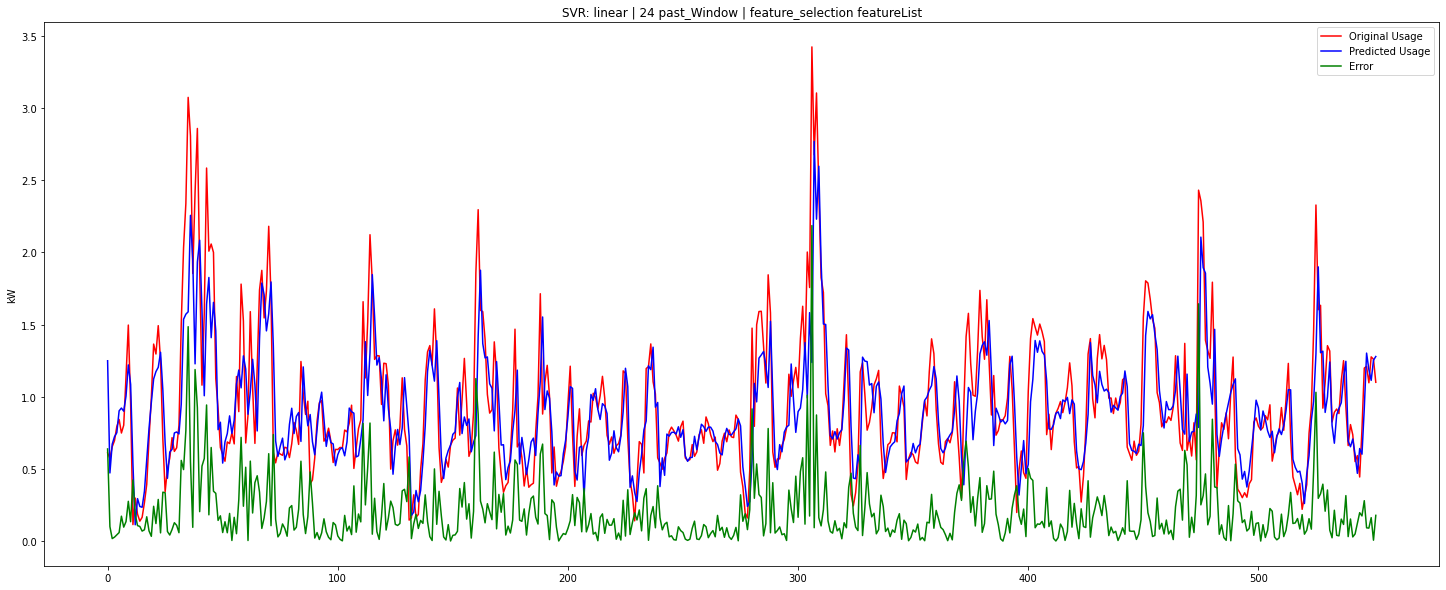

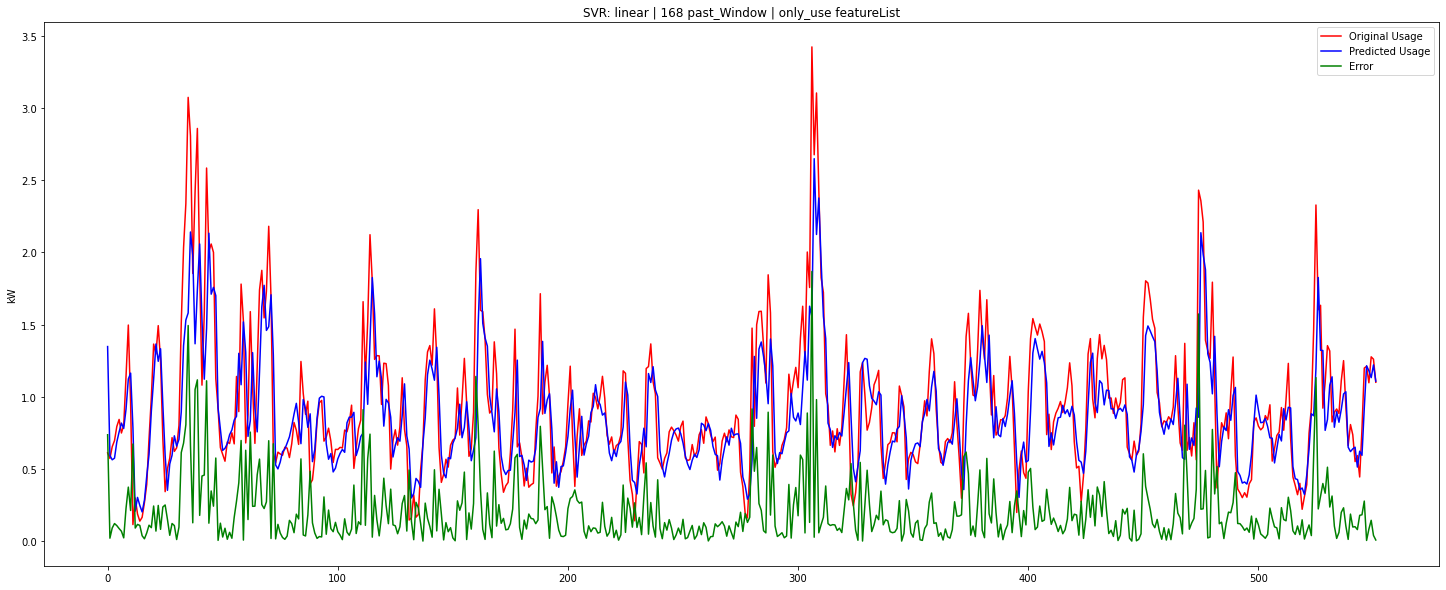

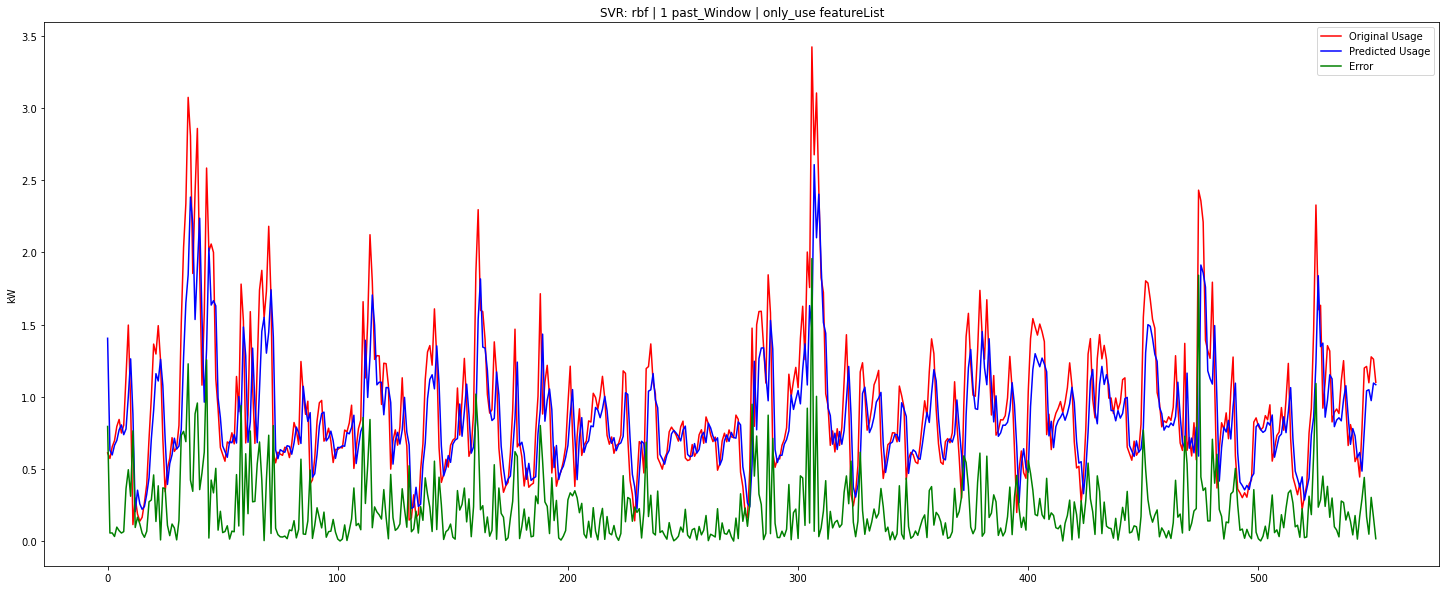

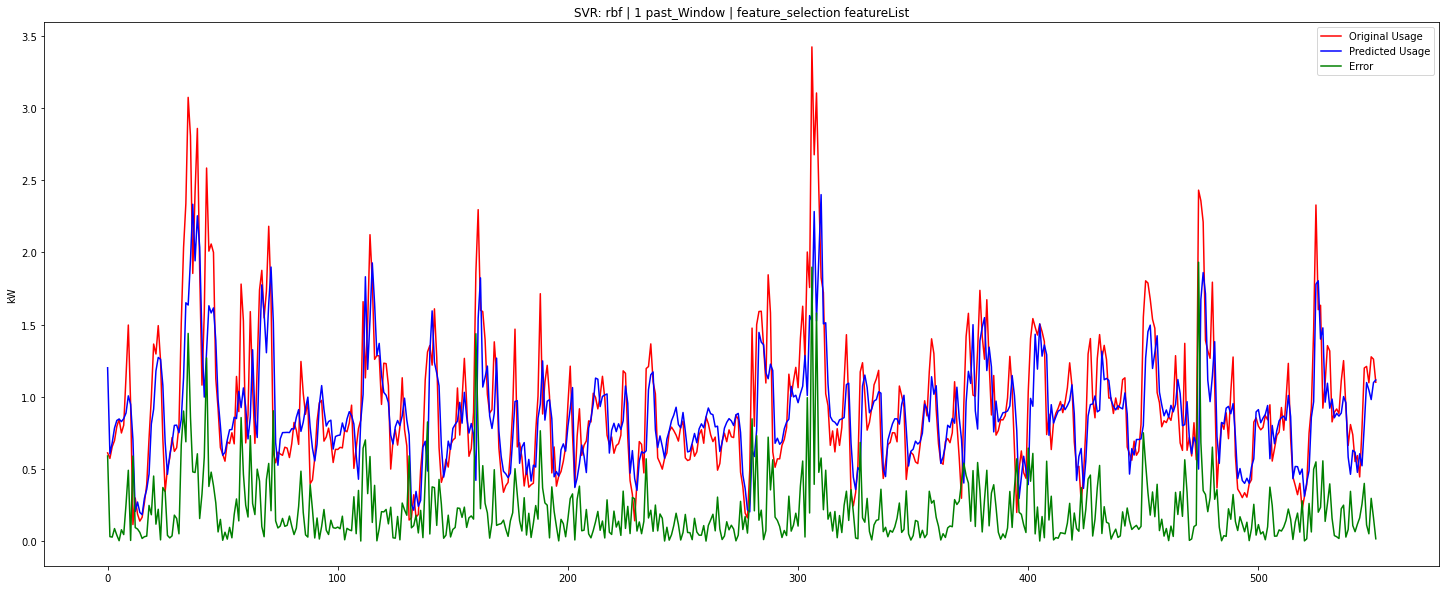

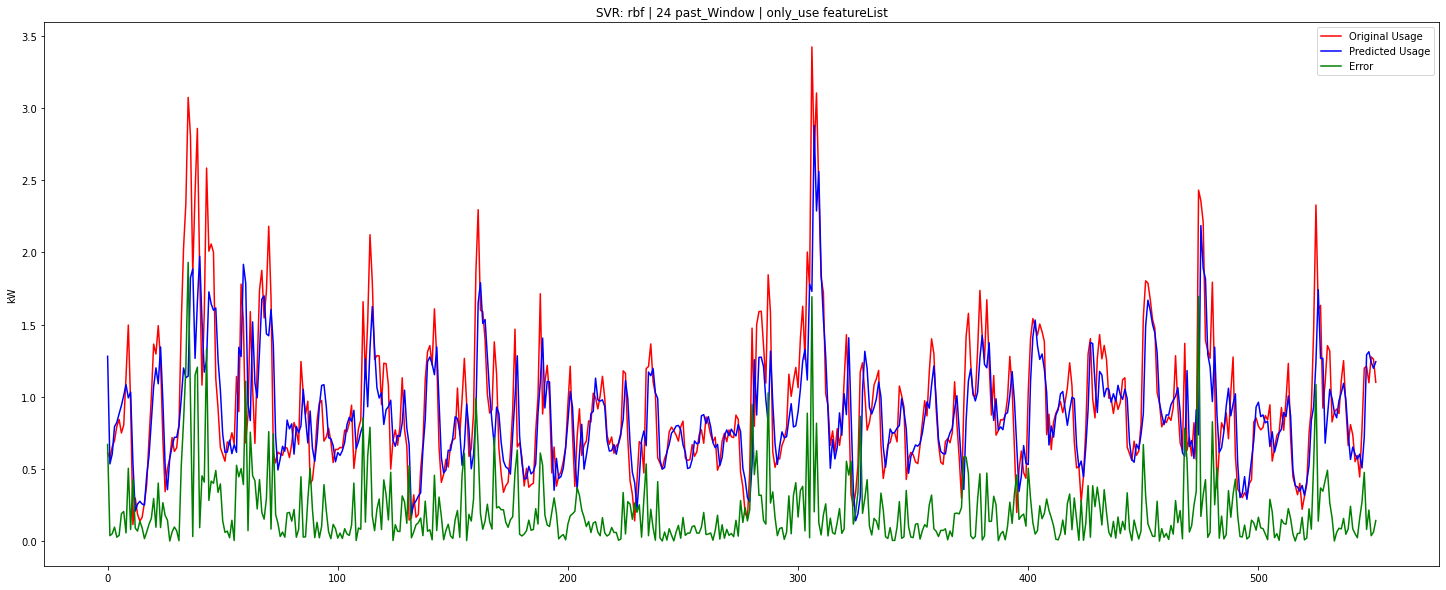

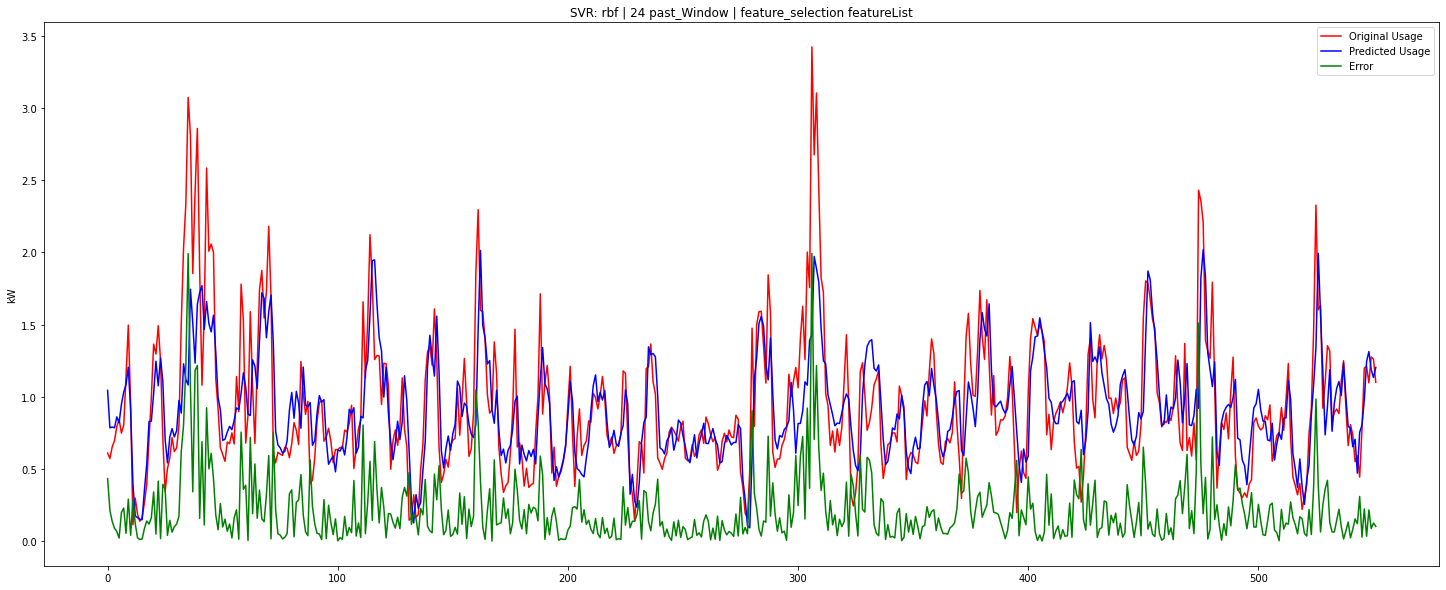

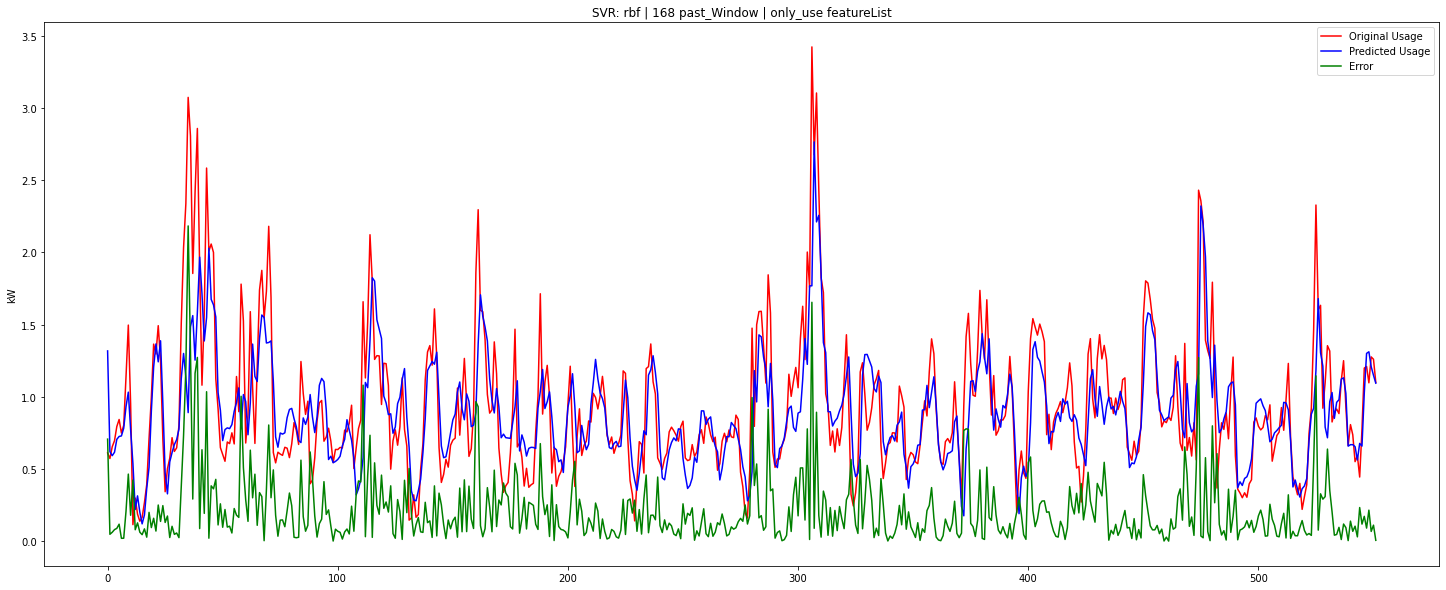

In [52]:
TARGET_NAME = "use"
PAST_WINDOWS = [1, 24, 7*24]
FEATURE_NAMES = {"only_use": ["use"],
                 "feature_selection":feature_selection}  #TODAS AS FEATURES DEMORA MUITO TEMPO
KERNELS = ["linear","rbf"]

resultsSVR = []
for kernel in KERNELS:
    for past_window in PAST_WINDOWS:
        for featuresName, featurelist in FEATURE_NAMES.items():
            if past_window == 24*7 and featuresName != "only_use": #DEMORA DEMASIADO TEMPO
                continue
            
            t1= time.time()
            name = "SVR: " + kernel + " | " + str(past_window) + " past_Window | " + featuresName + " featureList"
            result = make_svr(df, featurelist, TARGET_NAME, past_window, kernel,name=name)     
            result['time']=time.time()-t1
            
            resultsSVR.append(result)


In [53]:
from prettytable import PrettyTable

resultsSVR.sort(key=lambda x: x['mape'])
t = PrettyTable(['Name', 'mape', 'mae', 'maxae', 'mse'])

for r in resultsSVR:
    t.add_row([r['name'], round(r['mape'], 3), round(r['mae'], 3), round(r['maxae'], 3), round(r['mse'], 3)])

print(t)

+--------------------------------------------------------------+-------+-------+-------+-------+
|                             Name                             |  mape |  mae  | maxae |  mse  |
+--------------------------------------------------------------+-------+-------+-------+-------+
|       SVR: rbf | 24 past_Window | only_use featureList       | 0.244 | 0.206 | 1.931 | 0.101 |
|     SVR: linear | 168 past_Window | only_use featureList     | 0.246 | 0.203 | 1.868 | 0.094 |
| SVR: linear | 24 past_Window | feature_selection featureList | 0.247 | 0.202 | 2.186 | 0.092 |
|   SVR: rbf | 1 past_Window | feature_selection featureList   | 0.251 | 0.211 | 1.932 |  0.1  |
|     SVR: linear | 24 past_Window | only_use featureList      | 0.256 |  0.21 | 1.885 | 0.099 |
| SVR: linear | 1 past_Window | feature_selection featureList  | 0.257 | 0.215 | 2.069 | 0.102 |
|      SVR: rbf | 168 past_Window | only_use featureList       |  0.26 | 0.213 | 2.184 | 0.103 |
|  SVR: rbf | 24 past_Window |

1 semana de past window foi avaliada apenas com informação do uso porque com mais features demora demasiado tempo.  
Melhor SVR tem 24 horas de past window e apenas usa o consumo energético. Este modelo é melhor que a melhor LSTM

# ARIMA

ARIMA não foi testado a fundo nem com uma dimenção de teste tão grande como nos outros algoritmos porque demora muito tempo e numa fase inicial mostrou ter resultados piores

In [17]:
from statsmodels.tsa.arima.model import ARIMA

train = [x for x in df["use"][:-300].values]
test = [x for x in df["use"][-300:].values]

prediction = list()
for t in range(len(test)):
    model = ARIMA(train, order=(5,1,0))
    model = model.fit()
    pred = model.forecast()[0]

    prediction.append(pred)
    train.append(test[t])
    print('progress:%',round(100*(t/len(test))), end="\r")


Mean Absolute Percentage Error:  0.2607216191658445
Mean Absolute Error:  0.217471626004145
Max Absolute Error:  1.7704769419139414
Mean Squared Error:  0.10359649958626205


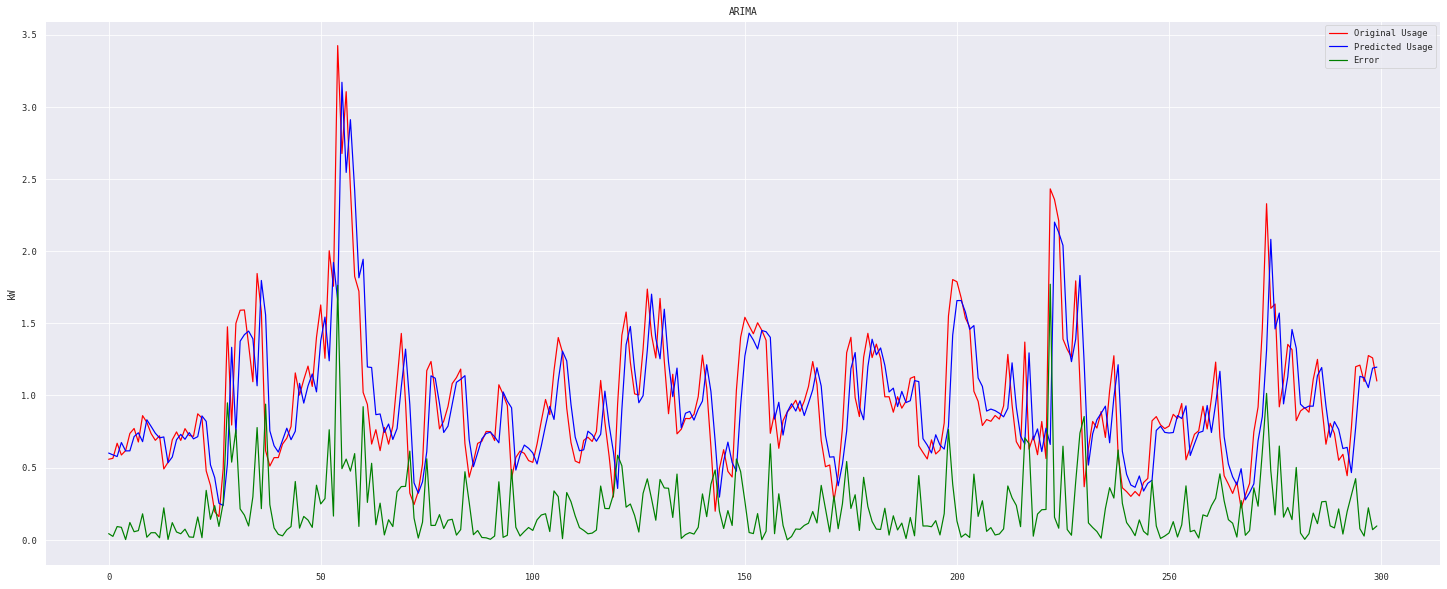

In [18]:
diff = [abs(prediction[i]-test[i]) for i in range(len(prediction))]

plt.figure(figsize=(25,10))
plt.plot(test, color='red', label='Original Usage')
plt.plot(prediction, color='blue', label='Predicted Usage')
plt.plot(diff, color='green', label='Error')
plt.title("ARIMA")
plt.ylabel('kW')
plt.legend()
plt.show

mape = mean_absolute_percentage_error(test, prediction)
mae = mean_absolute_error(test, prediction)
maxae = max(diff)
mse = mean_squared_error(test, prediction)
print("Mean Absolute Percentage Error: ", mape)
print("Mean Absolute Error: ", mae)
print("Max Absolute Error: ", maxae)
print("Mean Squared Error: ", mse)